In [1]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

# Steg 1: Importere og preparere datasettet
#### Bruker datasettet til én av de fire spillerne vi har valgt ut og velger hva vi ønsker å predikere
#### Her velger vi ut kun 'Readiness' som parameter, og tar med oss datoene i tillegg.
#### Deretter vil vi konvertere 'Date'-kolonnen til datetime.
#### Håndterer også manglende data med hjelp av forward-fill.

In [2]:
url = '../Spiller2.csv'
prediksjon = 'Readiness'
data = pd.read_csv(url, sep=',')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data = data.iloc[1: , :]
data[prediksjon] = data[prediksjon].fillna(method='ffill')
data

,Date,Fatigue,Mood,Readiness,Sleep Durhation,Sleep Quality,Soreness,Stress
1,2020-03-21,3.0,3.0,6.0,10.0,4.0,2.0,3.0
2,2020-03-22,2.0,3.0,1.0,10.0,3.0,2.0,3.0
3,2020-03-23,3.0,3.0,6.0,9.0,4.0,2.0,3.0
4,2020-03-24,2.0,2.0,6.0,9.0,4.0,2.0,3.0
5,2020-03-25,2.0,3.0,5.0,9.0,2.0,2.0,3.0
...,...,...,...,...,...,...,...,...
647,2021-12-27,3.0,3.0,6.0,8.0,2.0,2.0,3.0
648,2021-12-28,3.0,2.0,5.0,9.0,3.0,2.0,3.0
649,2021-12-29,3.0,3.0,6.0,8.5,2.0,2.0,3.0
650,2021-12-30,3.0,3.0,6.0,8.0,2.0,2.0,3.0


# Steg 2: Splitte datasettet i trening- og test-sett
#### Setter verdi 3 for lags
#### Deler opp datasettet i to der treningsettet er 520 og testsettet er 131 punkter. 

In [3]:
lags = 3

train_df, test_df = train_test_split(
    data, test_size=0.2, random_state=0, shuffle=False)

# Reset index for proper slicing
train_df = train_df.reset_index()
test_df = test_df.reset_index()

train_set = train_df[prediksjon].values
test_set = test_df[prediksjon].values

train_df

,index,Date,Fatigue,Mood,Readiness,Sleep Durhation,Sleep Quality,Soreness,Stress
0,1,2020-03-21,3.0,3.0,6.0,10.0,4.0,2.0,3.0
1,2,2020-03-22,2.0,3.0,1.0,10.0,3.0,2.0,3.0
2,3,2020-03-23,3.0,3.0,6.0,9.0,4.0,2.0,3.0
3,4,2020-03-24,2.0,2.0,6.0,9.0,4.0,2.0,3.0
4,5,2020-03-25,2.0,3.0,5.0,9.0,2.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...
515,516,2021-08-18,3.0,3.0,8.0,7.5,3.0,3.0,3.0
516,517,2021-08-19,3.0,3.0,6.0,9.0,3.0,2.0,3.0
517,518,2021-08-20,3.0,3.0,7.0,10.0,2.0,2.0,3.0
518,519,2021-08-21,3.0,3.0,8.0,9.0,3.0,2.0,3.0


# Steg 3: Omforme data til (values, time-steps, dimensional output)

In [4]:
# Funksjonsskalering
sc = MinMaxScaler(feature_range = (0, 1))

train_set_scaled = sc.fit_transform(train_set.reshape(-1, 1))
test_set_scaled = sc.transform(test_set.reshape(-1, 1))

# Oppretter en datastruktur med 60 time-steps og 1 output
X_train = []
y_train = []

X_test = []
y_test = []

for i in range(len(train_set_scaled) - lags):
    X_train.append(train_set_scaled[i : i + lags, 0])
    y_train.append(train_set_scaled[i + lags, 0])
    
for i in range(len(test_set_scaled) - lags):
    X_test.append(test_set_scaled[i : i + lags, 0])
    y_test.append(test_set_scaled[i + lags, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(517, 3, 1) (517,)
(128, 3, 1) (128,)


# Steg 4: Bygge opp LSTM ved hjelp av treningsettet
#### Bygger opp modellen med neural network. Legger til 50 neurons og 4 skjulte lag.

In [5]:
model = Sequential()
# Legger til det første LSTM-laget og litt Dropout-regularisering
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Legger til et andre LSTM-lag og litt Dropout-regularisering
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Legger til et tredje LSTM-lag og noe utfallsregularisering
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Legger til et fjerde LSTM-lag og litt Dropout-regularisering
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Legger til output layer
model.add(Dense(units = 1))

# Kompilerer RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Tilpasser RNN til treningssettet
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

2022-05-22 02:32:56.190014: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
17/17 [==============================] - 5s 7ms/step - loss: 0.3500
Epoch 2/100
17/17 [==============================] - 0s 7ms/step - loss: 0.0644
Epoch 3/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0210
Epoch 4/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0161
Epoch 5/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0152
Epoch 6/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0161
Epoch 7/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0152
Epoch 8/100
17/17 [==============================] - 0s 12ms/step - loss: 0.0163
Epoch 9/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0150
Epoch 10/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0155
Epoch 11/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0150
Epoch 12/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0157
Epoch 13/100
17/17 [================

### Lager prediksjoner ved å bruke test-settet.

In [6]:
predikterte_readiness = model.predict(X_test)

pred_readiness = sc.inverse_transform(predikterte_readiness)
ekte_readiness = sc.inverse_transform(y_test.reshape(-1, 1))

### Fremstiller en tabell som viser prediskjonene og den ekte verdien.

In [7]:
dataPredikerteReadiness = pd.DataFrame(pred_readiness, columns=["Predikerte Readiness"])
dataEkteReadiness = pd.DataFrame(ekte_readiness, columns=["Ekte Readiness"])
df_prediksjon = pd.concat([dataPredikerteReadiness, dataEkteReadiness], axis=1)
df_prediksjon.head(10)

,Predikerte Readiness,Ekte Readiness
0,6.405994,6.0
1,6.433221,7.0
2,6.423411,8.0
3,6.409758,5.0
4,6.442985,6.0
5,6.436972,6.0
6,6.357498,7.0
7,6.392392,7.0
8,6.405994,7.0
9,6.436986,8.0


# Steg 5: Visualisere prediksjonen

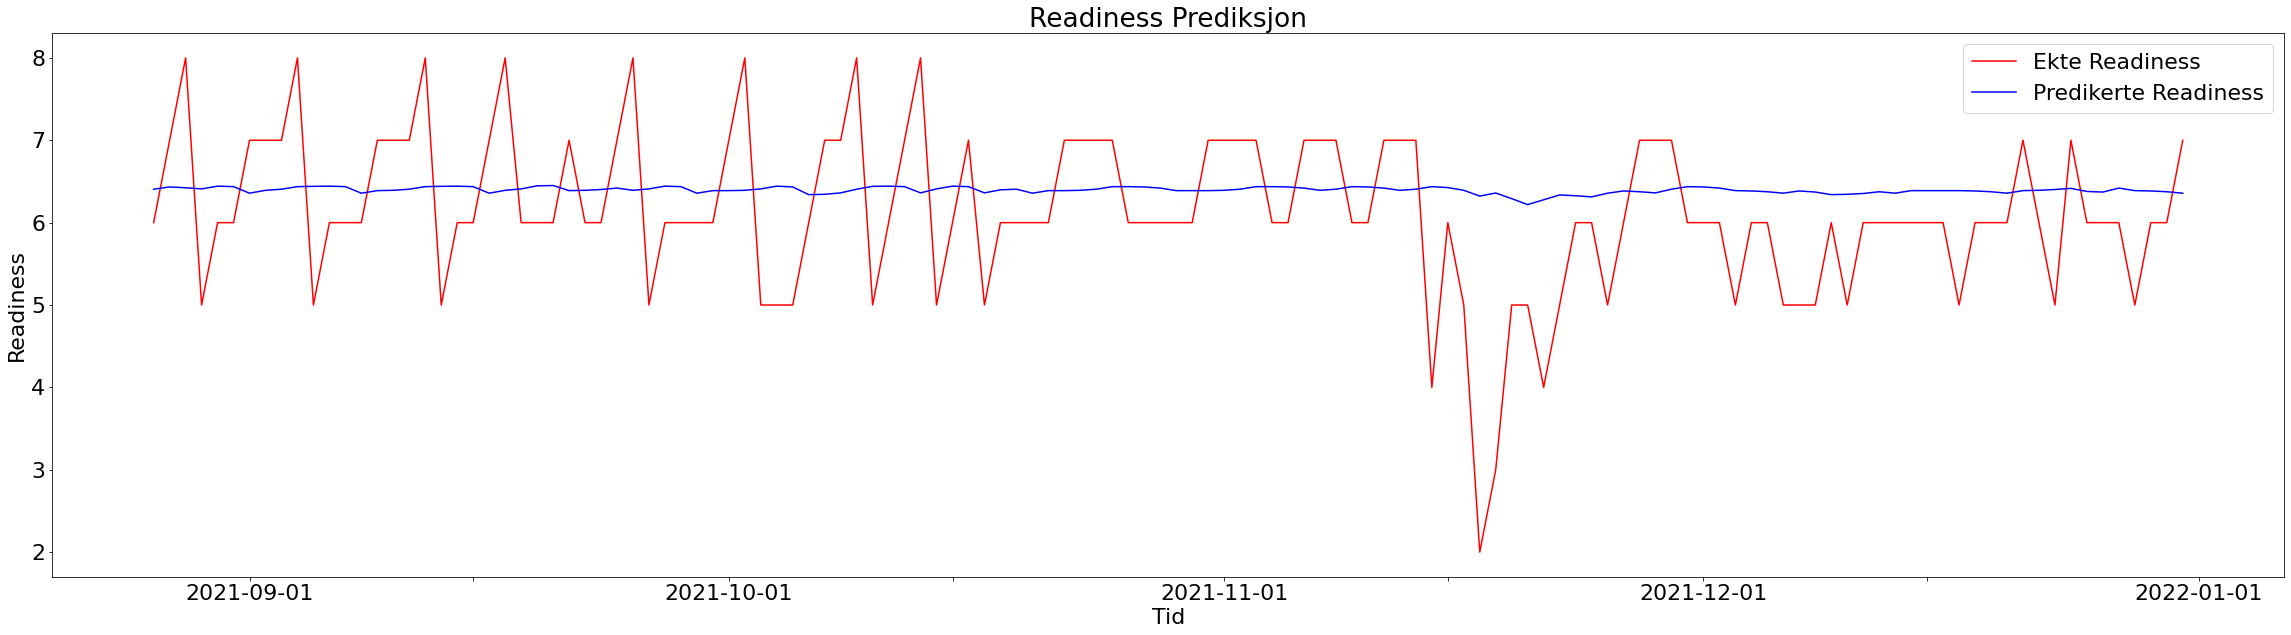

In [10]:
# Visualisere resultatene

fig, ax = plt.subplots()

plt.plot(test_df.loc[lags:, 'Date'], ekte_readiness, color = 'red', label = 'Ekte Readiness')
plt.plot(test_df.loc[lags:, 'Date'], pred_readiness, color = 'blue', label = 'Predikerte Readiness')

# Rengjør x labels
every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.title('Readiness Prediksjon')
plt.xlabel('Tid')
plt.ylabel('Readiness')
plt.rcParams["figure.figsize"] = (40,10)
plt.rcParams.update({'font.size': 22})

plt.legend()
plt.show()

## Måling av modellen - Test-error
#### Til slutt kan vi måle opp hvor god prediksjonen er opp mot en test-error.
#### Velger MSE som test-error som gir oss en verdi som skal være så nærme 0 som mulig.

In [9]:
error_mse = mean_squared_error(
    y_true = ekte_readiness, y_pred = pred_readiness)

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.9973789784877276
